__Purpose:__ Introduce Federated Learning, specifically by implementing FedAveraging on our dataset and moving on to more advanced methods.  Start by modifying the Simulations code, worry about (a)synchronicity later.
<br>
1. We are assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

In [2]:
from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

In [4]:
bad_nodes = [1,3,13]

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


# Create Federated Set Up

In [5]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

In [6]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

Quick runs just to make sure each algo runs without issues

In [7]:
#Check streaming condition
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0) for i in range(14)]
global_model = Server(-100, D_0_7, 'FedAvg', user_c0_etascipy_streaming)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

#Check full data condition
user_c0_etascipy_full = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'full_data', delay_scaling=0) for i in range(14)]
global_model = Server(-101, D_0_7, 'FedAvg', user_c0_etascipy_full)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

#Check advance_each_iter condition
user_c0_etascipy_advance = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model = Server(-102, D_0_7, 'FedAvg', user_c0_etascipy_advance)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check the non-PCA case now... this is no longer the default
> This one should overwrite

In [8]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model = Server(-103, D_0_7, 'FedAvg', user_c0_etascipy_streaming, PCA_comps=64)

global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
print()
print("Global Error Log")
print(global_model.global_error_log)
print()
print("Local Error Log")
print(global_model.local_error_log)
print()
print("Confirmation that no PCA happened (size should be 64)")
print(user_c0_etascipy_streaming[0].w.shape)
print(user_c0_etascipy_streaming[0].w_prev.shape)

Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decode

## Double Checking Running the No-FL Case
> We should see some kind of convergence
> TURNING PCA OFF FOR THIS CASE SINCE SIMS DID NOT HAVE IT

In [9]:
user_c0_fullscipy = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl = Server(-1, D_0, 'NoFL', user_c0_fullscipy, PCA_comps=64)
print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Global Round: 0

Local Round: 0
Local Update: 0


In [10]:
global_model_no_fl.execute_FL_loop()

print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Global Round: 1

Local Round: 1
Local Update: 1


In [11]:
# We are at update 2/19.  Therefore 19-2=17-1=16
num_updates_left = 16
for i in range(num_updates_left):
    global_model_no_fl.execute_FL_loop()
print("Complete")
print()
print()
print()
print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Complete



Global Round: 17

Local Round: 17
Local Update: 17


Check the performance... should approximately mirror the previous NB, or at least show that error is decreasing...

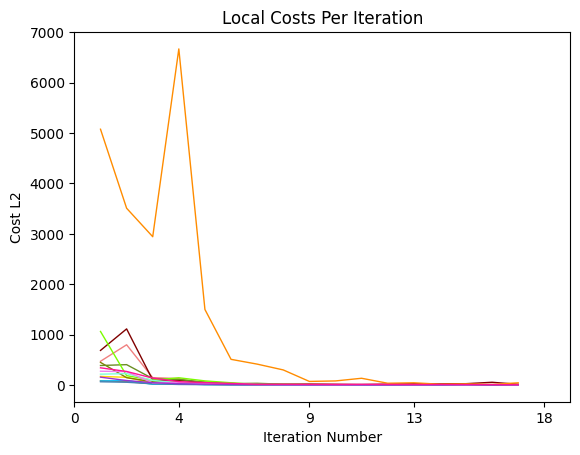

In [12]:
external_plot_error(user_c0_fullscipy, global_error=False, dim_reduc_factor=1, show_update_change=False)

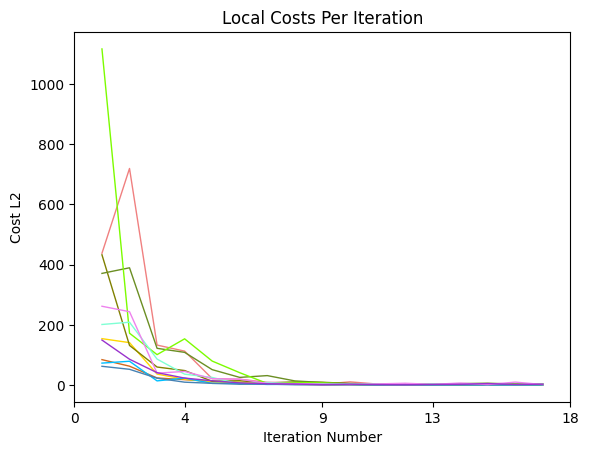

In [13]:
external_plot_error(user_c0_fullscipy, exclusion_lst=bad_nodes, global_error=False, dim_reduc_factor=1, show_update_change=False)

Save Decs to compare to sims

In [14]:
all_user_decs_no_fl = [user_c0_fullscipy[i].dec_log for i in range(num_participants)]

#with open(path+nofl_decs_filename, 'wb') as fp:
#    pickle.dump(all_user_decs_no_fl, fp, protocol=pickle.HIGHEST_PROTOCOL)

__Retry but now use the init decs that we loaded in instead of the random inits__

In [15]:
user_c0_fullscipy_winit = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_winit = Server(-1, D_0, 'NoFL', user_c0_fullscipy_winit, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_winit.execute_FL_loop()
print(f"Global Round: {global_model_no_fl_winit.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy_winit[0].current_round}")
print(f"Local Update: {user_c0_fullscipy_winit[0].current_update}")

Global Round: 18

Local Round: 18
Local Update: 17


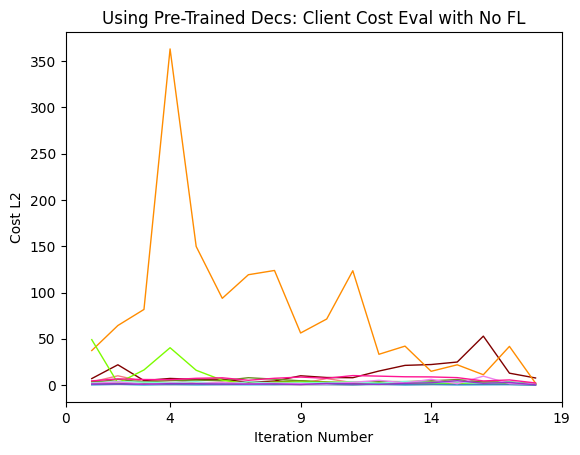

In [17]:
external_plot_error(user_c0_fullscipy_winit, global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using Pre-Trained Decs: Client Cost Eval with No FL')

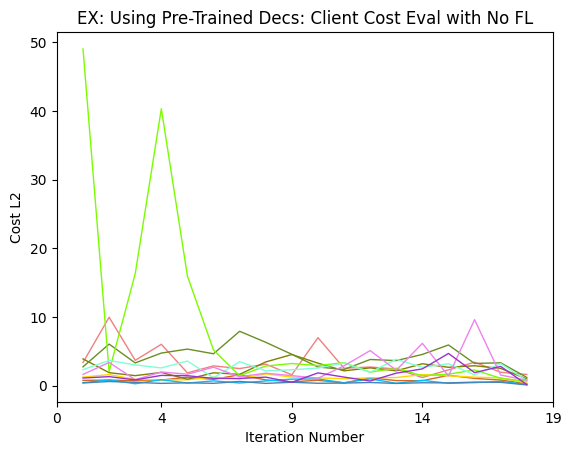

In [19]:
external_plot_error(user_c0_fullscipy_winit, global_error=False, dim_reduc_factor=1, exclusion_lst=bad_nodes, show_update_change=False, custom_title='EX: Using Pre-Trained Decs: Client Cost Eval with No FL')

## 1 Scipy Step, 2000 Iterations

In [20]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()

Client 1: New update after lrt passed: (new update, current round): (11, 50)

Client 1: New update after lrt passed: (new update, current round): (12, 100)

Client 1: New update after lrt passed: (new update, current round): (13, 150)

Client 1: New update after lrt passed: (new update, current round): (14, 200)

Client 1: New update after lrt passed: (new update, current round): (15, 250)

Client 1: New update after lrt passed: (new update, current round): (16, 300)



In [21]:
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(302, 16)
(301, 16)
(293, 15)
(269, 15)
(281, 15)
(277, 15)
(259, 15)
(288, 15)
(306, 16)
(257, 15)
(327, 16)
(277, 15)
(304, 16)
(259, 15)


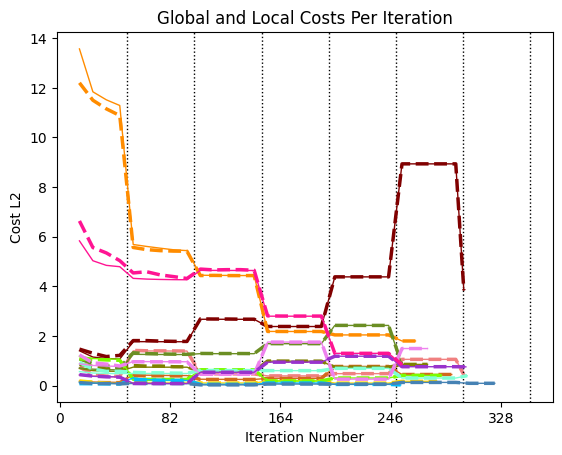

In [23]:
external_plot_error(user_c0_1ScipyStep)

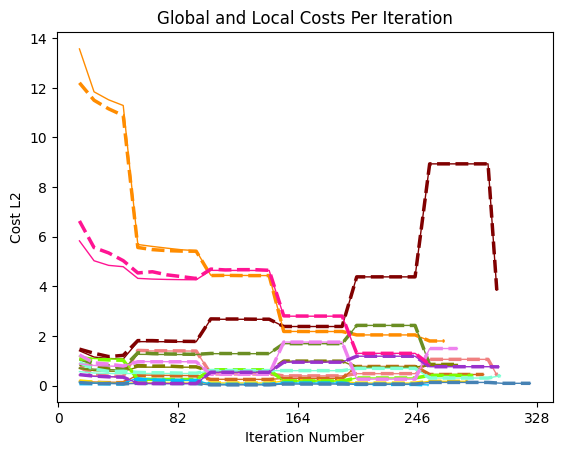

In [24]:
external_plot_error(user_c0_1ScipyStep, show_update_change=False)

__Redoing but setting the local threshold for update to be much lower__
> NOTE THAT I CHANGED THE DEFUALT LIM TO 50 IN THE CODE ANYWAYS SO THIS SHOULD BE THE SAME
> Is it completely deterministic?

In [25]:
reduced_limit = 50

user_c0_1ScipyStep_lim50 = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_lim50 = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_lim50)

for i in range(big_loop_iters):
    global_model_1scipystep_lim50.execute_FL_loop()

Client 1: New update after lrt passed: (new update, current round): (11, 50)

Client 1: New update after lrt passed: (new update, current round): (12, 100)

Client 1: New update after lrt passed: (new update, current round): (13, 150)

Client 1: New update after lrt passed: (new update, current round): (14, 200)

Client 1: New update after lrt passed: (new update, current round): (15, 250)



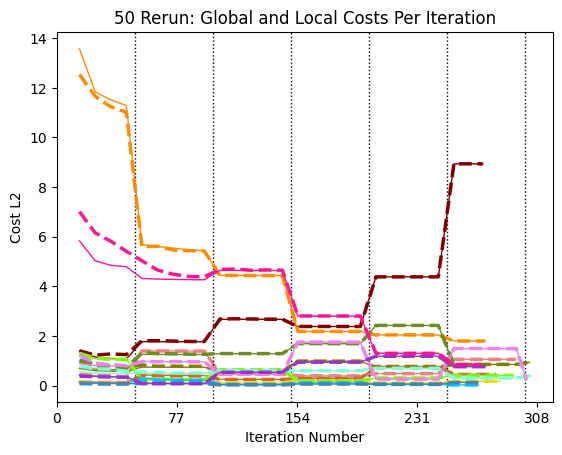

In [27]:
external_plot_error(user_c0_1ScipyStep_lim50, custom_title='50 Rerun: Global and Local Costs Per Iteration')

__Repeat but now actually make it much smaller__

In [28]:
reduced_limit = 25

user_c0_1ScipyStep_lim25 = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_lim25 = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_lim25)

for i in range(big_loop_iters):
    global_model_1scipystep_lim25.execute_FL_loop()

Client 1: New update after lrt passed: (new update, current round): (11, 25)

Client 1: New update after lrt passed: (new update, current round): (12, 50)

Client 1: New update after lrt passed: (new update, current round): (13, 75)

Client 1: New update after lrt passed: (new update, current round): (14, 100)

Client 1: New update after lrt passed: (new update, current round): (15, 125)

Client 1: New update after lrt passed: (new update, current round): (16, 150)

Client 1: New update after lrt passed: (new update, current round): (17, 175)



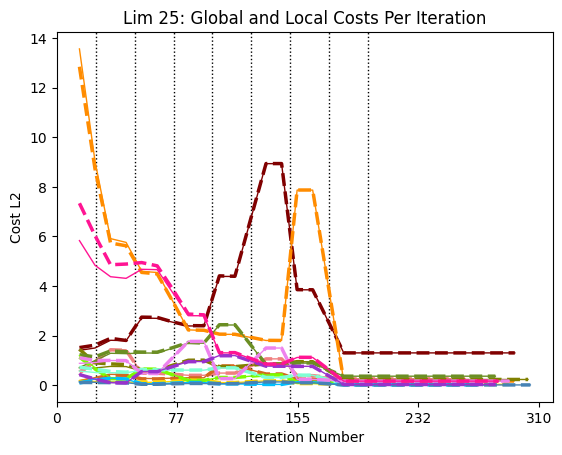

In [30]:
external_plot_error(user_c0_1ScipyStep_lim25, custom_title='Lim 25: Global and Local Costs Per Iteration')

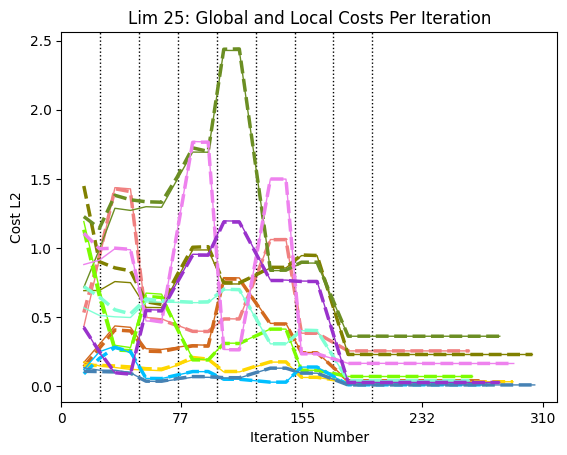

In [32]:
external_plot_error(user_c0_1ScipyStep_lim25, exclusion_lst=bad_nodes, custom_title='Lim 25: Global and Local Costs Per Iteration')

__This time, use the final global model as the init instead of a random init__
> Compare against using the local model? Doesn't help for new clients...

In [33]:
global_model_1scipystep_lim25.w

array([[-0.0036629 ,  0.00523376, -0.00078354, -0.0007708 ,  0.00192455,
         0.00190304,  0.01379749],
       [-0.00142125, -0.00205194,  0.00037052,  0.00130875,  0.00163929,
         0.00514145,  0.00862548]])

In [34]:
user_c0_1ScipyStep_globaldec = [Client(i, global_model_1scipystep_lim25.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_globaldecinit = Server(1, global_model_1scipystep_lim25.w, 'FedAvg', user_c0_1ScipyStep_globaldec)

for i in range(big_loop_iters):
    global_model_globaldecinit.execute_FL_loop()

Client 1: New update after lrt passed: (new update, current round): (11, 25)

Client 1: New update after lrt passed: (new update, current round): (12, 50)

Client 1: New update after lrt passed: (new update, current round): (13, 75)

Client 1: New update after lrt passed: (new update, current round): (14, 100)

Client 1: New update after lrt passed: (new update, current round): (15, 125)

Client 1: New update after lrt passed: (new update, current round): (16, 150)

Client 1: New update after lrt passed: (new update, current round): (17, 175)



In [35]:
for my_client in global_model_globaldecinit.all_clients:
    print((my_client.current_round, my_client.current_update))

(263, 17)
(312, 17)
(286, 17)
(276, 17)
(262, 17)
(308, 17)
(315, 17)
(298, 17)
(278, 17)
(290, 17)
(261, 17)
(284, 17)
(303, 17)
(264, 17)


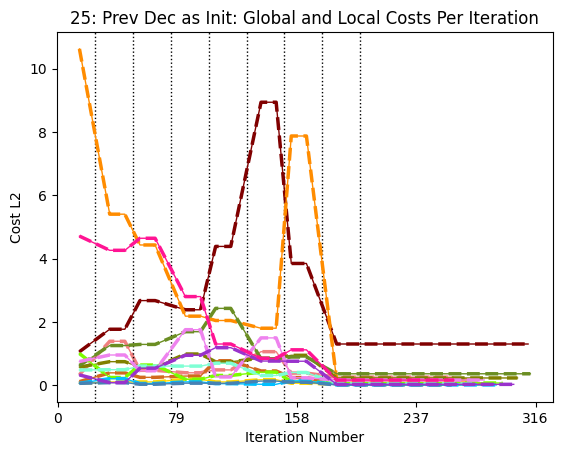

In [37]:
external_plot_error(user_c0_1ScipyStep_globaldec, custom_title='25: Prev Dec as Init: Global and Local Costs Per Iteration')

I can't tell much difference between the sets of plots, using the Previous Global Dec as the init...

__Retry but use both prev local AND global models__

In [38]:
user_c0_1ScipyStep_globalandlocaldec = [Client(i, user_c0_1ScipyStep_lim25[i].w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_globalandlocaldec = Server(1, global_model_1scipystep_lim25.w, 'FedAvg', user_c0_1ScipyStep_globalandlocaldec)

for i in range(big_loop_iters):
    global_model_globalandlocaldec.execute_FL_loop()

Client 1: New update after lrt passed: (new update, current round): (11, 25)

Client 1: New update after lrt passed: (new update, current round): (12, 50)

Client 1: New update after lrt passed: (new update, current round): (13, 75)

Client 1: New update after lrt passed: (new update, current round): (14, 100)

Client 1: New update after lrt passed: (new update, current round): (15, 125)

Client 1: New update after lrt passed: (new update, current round): (16, 150)

Client 1: New update after lrt passed: (new update, current round): (17, 175)



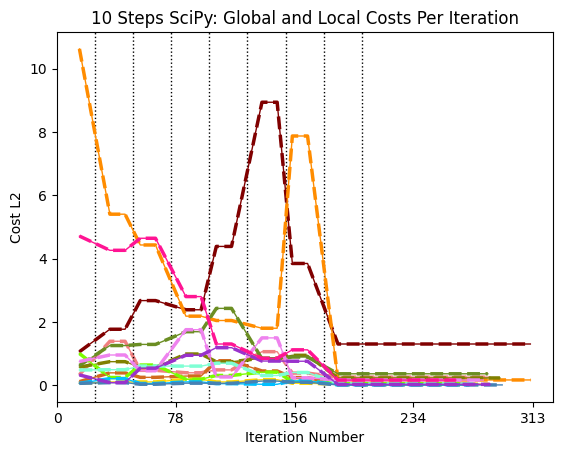

In [41]:
external_plot_error(user_c0_1ScipyStep_globalandlocaldec, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

## 10 Steps

In [42]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()

In [43]:
for my_client in global_model_globaldecinit.all_clients:
    print((my_client.current_round, my_client.current_update))

(263, 17)
(312, 17)
(286, 17)
(276, 17)
(262, 17)
(308, 17)
(315, 17)
(298, 17)
(278, 17)
(290, 17)
(261, 17)
(284, 17)
(303, 17)
(264, 17)


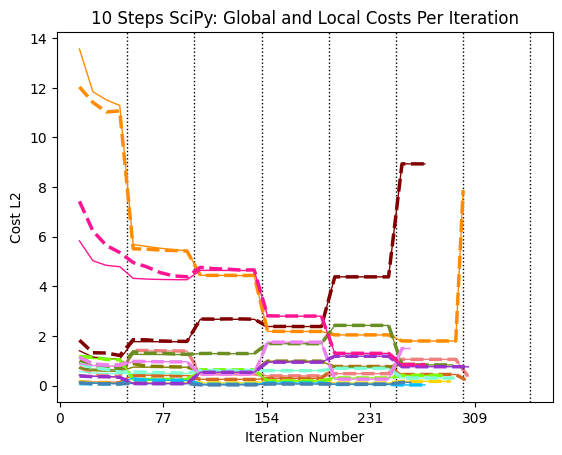

In [46]:
external_plot_error(user_c0_10scipy, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

__I'll retry now but using the final global model from above__

In [47]:
user_c0_10scipy_prevglobaldec = [Client(i, global_model_10scipy.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy_prevglobaldec = Server(2, global_model_10scipy.w, 'FedAvg', user_c0_10scipy_prevglobaldec)

for i in range(big_loop_iters):
    global_model_10scipy_prevglobaldec.execute_FL_loop()

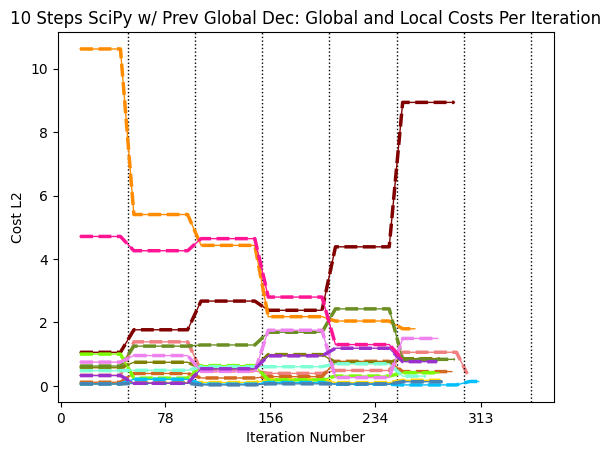

In [50]:
external_plot_error(user_c0_10scipy_prevglobaldec, custom_title='10 Steps SciPy w/ Prev Global Dec: Global and Local Costs Per Iteration')

__I'll retry now but using the final global AND local models from the run above the above__

In [51]:
user_c0_10scipy_ALLprevdec = [Client(i, user_c0_10scipy[i].w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy_ALLprevdec = Server(2, global_model_10scipy.w, 'FedAvg', user_c0_10scipy_ALLprevdec)

for i in range(big_loop_iters):
    global_model_10scipy_ALLprevdec.execute_FL_loop()

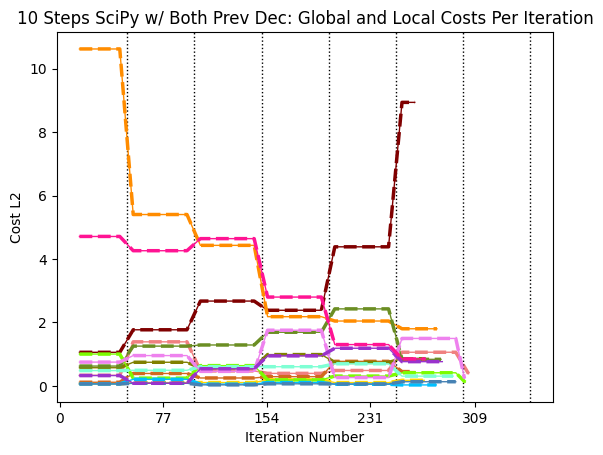

In [53]:
external_plot_error(user_c0_10scipy_ALLprevdec, custom_title='10 Steps SciPy w/ Both Prev Dec: Global and Local Costs Per Iteration')

## Full Scipy.Minimize

In [54]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy, C=1)

for i in range(18):
    global_model_fullscipy.execute_FL_loop()

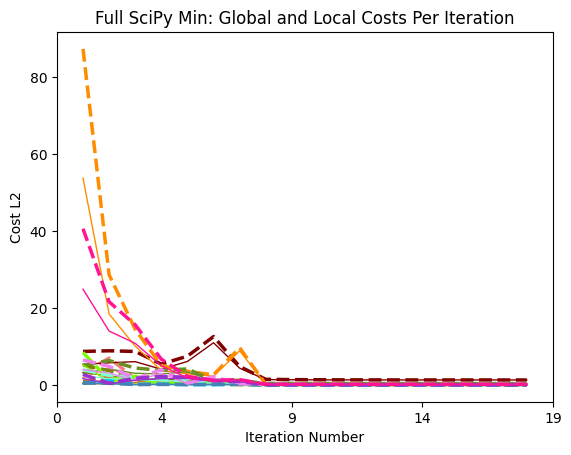

In [56]:
external_plot_error(user_c0_fullscipy, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')